# Fashion MNIST - CNN Tuning

### Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

## Business Understanding

### Load Data

In [2]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%
0.7%

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [3]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
test_set

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

9


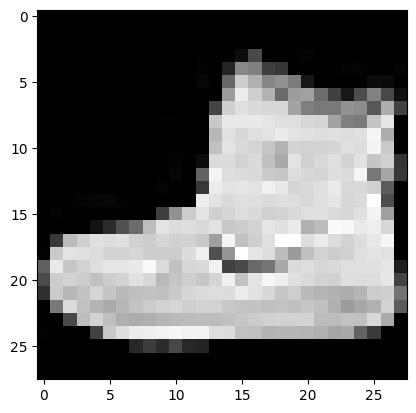

In [6]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

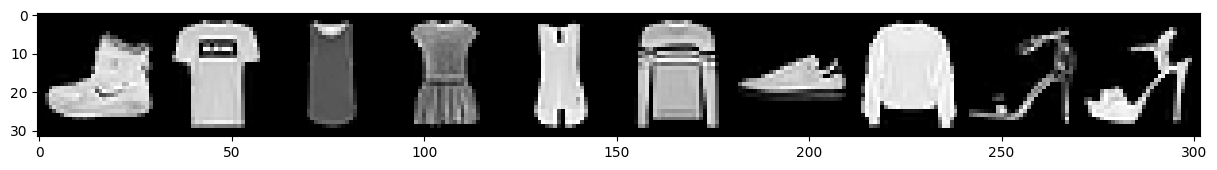

In [7]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [8]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Data Understanding

In [9]:
# Zugriff auf die Labels der Trainings- und Testdatensätze
train_labels = train_set.targets
test_labels = test_set.targets

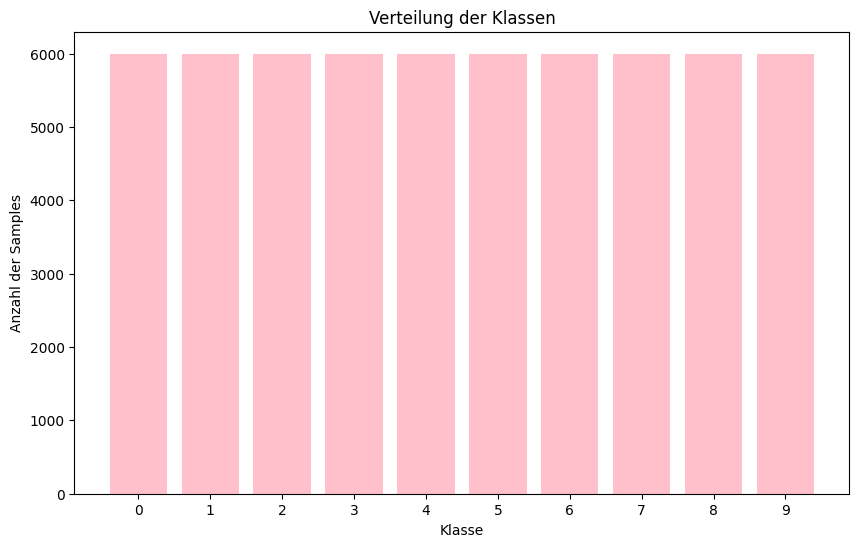

In [10]:
# Erstellen eines Pandas DataFrame, um die Klassenzuordnung und die Anzahl der Samples zu speichern
class_distribution = pd.DataFrame({'Class': np.arange(10), 'Count': np.bincount(train_labels)})

# Darstellen der Verteilung mit einem Balkendiagramm
plt.figure(figsize=(10, 6))
plt.bar(class_distribution['Class'], class_distribution['Count'], color='pink')
plt.xticks(class_distribution['Class'])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Samples')
plt.title('Verteilung der Klassen')
plt.show()

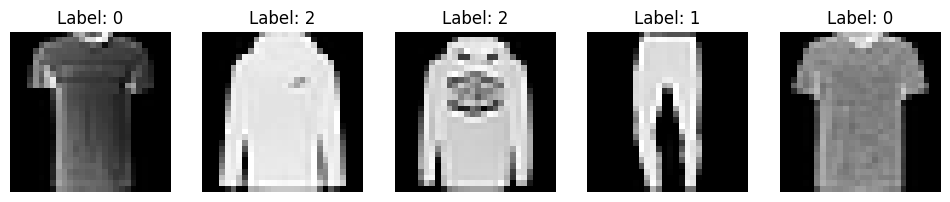

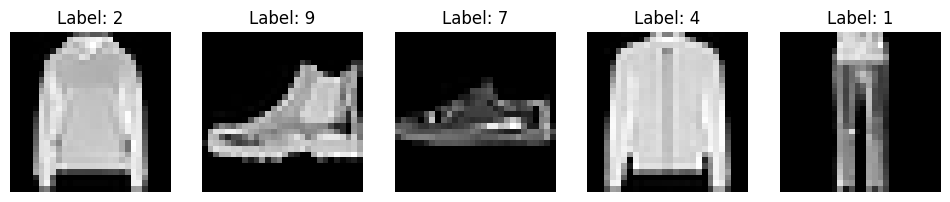

In [11]:
# Function to display random images with labels
def display_random_images(dataset, labels, num_images=5):
    # Generate random indices
    random_indices = np.random.randint(0, len(dataset), num_images)

    # Create a grid of subplots
    fig, axs = plt.subplots(1, num_images, figsize=(12, 6))

    # Display the random images with labels
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        axs[i].imshow(image.squeeze(), cmap='gray')  # Squeeze the image tensor to remove the channel dimension
        axs[i].set_title(f'Label: {label}')
        axs[i].axis('off')

    plt.show()

# Call the function to display 5 random images from the training set
display_random_images(train_set, train_labels, num_images=5)

# Call the function to display 5 random images from the test set
display_random_images(test_set, test_labels, num_images=5)

In [12]:
# Flatten the 2-dimensional images to 1-dimensional arrays
train_data = train_set.data.numpy().reshape(-1, 28 * 28)
test_data = test_set.data.numpy().reshape(-1, 28 * 28)

# Convert the datasets to DataFrames
train_df = pd.DataFrame(train_data, columns=[f"Pixel_{i}" for i in range(28 * 28)])
train_df["Label"] = pd.Series(train_set.targets.numpy())

test_df = pd.DataFrame(test_data, columns=[f"Pixel_{i}" for i in range(28 * 28)])
test_df["Label"] = pd.Series(test_set.targets.numpy())

# Display the head of the DataFrames (first few rows)
print(train_df.head())
print(test_df.head())

   Pixel_0  Pixel_1  Pixel_2  Pixel_3  Pixel_4  Pixel_5  Pixel_6  Pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        1        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   Pixel_8  Pixel_9  ...  Pixel_775  Pixel_776  Pixel_777  Pixel_778  \
0        0        0  ...          0          0          0          0   
1        0        0  ...        114        130         76          0   
2        0       22  ...          0          1          0          0   
3       33       96  ...          0          0          0          0   
4        0        0  ...          0          0          0          0   

   Pixel_779  Pixel_780  Pixel_781  Pixel_782  Pixel_783  Label  
0          0          0          0    

In [13]:
# Count the number of black pixels in each image
train_black_pixel_counts = np.sum(train_data == 0, axis=1)
test_black_pixel_counts = np.sum(test_data == 0, axis=1)

# Calculate the average number of black pixels across all images
train_avg_black_pixels = np.mean(train_black_pixel_counts)
test_avg_black_pixels = np.mean(test_black_pixel_counts)

print("Average black pixels in train images:", train_avg_black_pixels)
print("Average black pixels in test images:", test_avg_black_pixels)


Average black pixels in train images: 393.6083
Average black pixels in test images: 391.9183


In [14]:
import numpy as np
import pandas as pd


train_labels = train_set.targets.numpy()
test_labels = test_set.targets.numpy()

train_df = pd.DataFrame(train_data, columns=[f"Pixel_{i}" for i in range(28 * 28)])
train_df["Label"] = pd.Series(train_labels)

test_df = pd.DataFrame(test_data, columns=[f"Pixel_{i}" for i in range(28 * 28)])
test_df["Label"] = pd.Series(test_labels)

# Calculate the average number of black pixels per class
train_avg_black_pixels_per_class = train_df.groupby('Label').apply(lambda x: (x == 0).mean().mean())
test_avg_black_pixels_per_class = test_df.groupby('Label').apply(lambda x: (x == 0).mean().mean())

print("Average black pixels per class in train dataset:")
print(train_avg_black_pixels_per_class)

print("\nAverage black pixels per class in test dataset:")
print(test_avg_black_pixels_per_class)


Average black pixels per class in train dataset:
Label
0    0.406633
1    0.650493
2    0.350834
3    0.571363
4    0.397762
5    0.677994
6    0.370404
7    0.661229
8    0.413857
9    0.514823
dtype: float64

Average black pixels per class in test dataset:
Label
0    0.405772
1    0.646549
2    0.347526
3    0.566224
4    0.390775
5    0.677112
6    0.372101
7    0.661318
8    0.410748
9    0.515739
dtype: float64


## Data Preprocessing

In [16]:
# Define the size of your validation set (e.g., 20% of the training set)
validation_ratio = 0.2
dataset_size = len(train_set)
val_size = int(validation_ratio * dataset_size)
train_size = dataset_size - val_size

# Split the training dataset into training set and validation set
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

# Create data loaders for each dataset (training, validation, and test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [17]:
train_loader

## Modelling

### 1st Approach - ChatGPT

In [18]:
# model definition
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
# prepare data loaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
# define loss function + optimizer
model = FashionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [25]:
num_epochs = 10

# Lists to store loss and accuracy values during training
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

# Evaluate the trained model on the test dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/10, Loss: 0.1805, Accuracy: 93.40%
Epoch 2/10, Loss: 0.1563, Accuracy: 94.22%
Epoch 3/10, Loss: 0.1372, Accuracy: 94.94%
Epoch 4/10, Loss: 0.1176, Accuracy: 95.64%
Epoch 5/10, Loss: 0.0995, Accuracy: 96.32%
Epoch 6/10, Loss: 0.0830, Accuracy: 97.00%
Epoch 7/10, Loss: 0.0743, Accuracy: 97.29%
Epoch 8/10, Loss: 0.0592, Accuracy: 97.87%
Epoch 9/10, Loss: 0.0519, Accuracy: 98.17%
Epoch 10/10, Loss: 0.0455, Accuracy: 98.35%
Test Accuracy: 91.38%


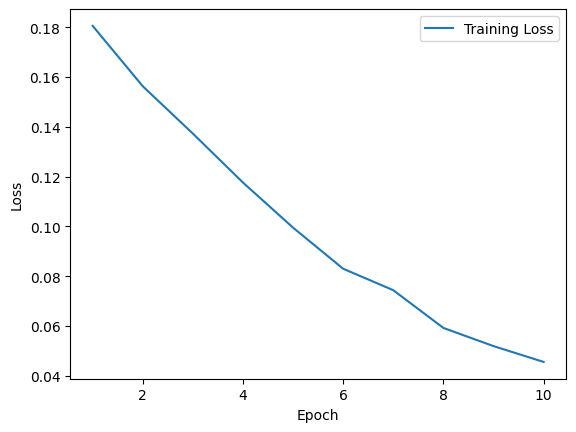

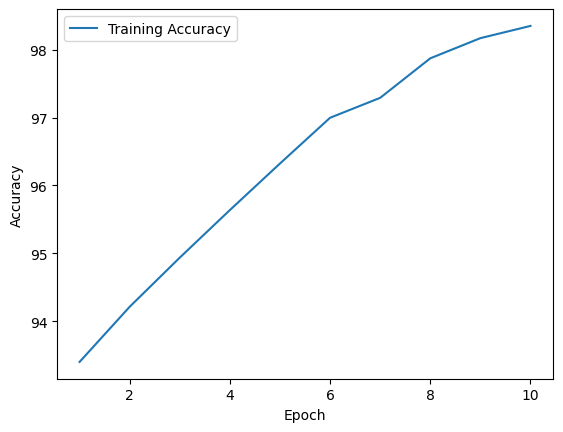

In [26]:
# Plotting Loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2nd approach - using GitHub example Sequential

In [27]:
from collections import OrderedDict
from torchvision import datasets, transforms

In [40]:
# Download training and testing data
train_ds = torchvision.datasets.FashionMNIST(root="./data", download=True, train=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
test_ds = torchvision.datasets.FashionMNIST(root="./data", download=True, train=False,
                                            transform=transforms.Compose([transforms.ToTensor()]))


In [41]:
# split train set into training (80%) and validation set (20%)
train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]
len(val_idx), len(train_idx)

(12000, 48000)

In [42]:
# prepare dataloaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=val_sampler)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

torch.Size([1, 28, 28]) torch.Size([64])
Bag


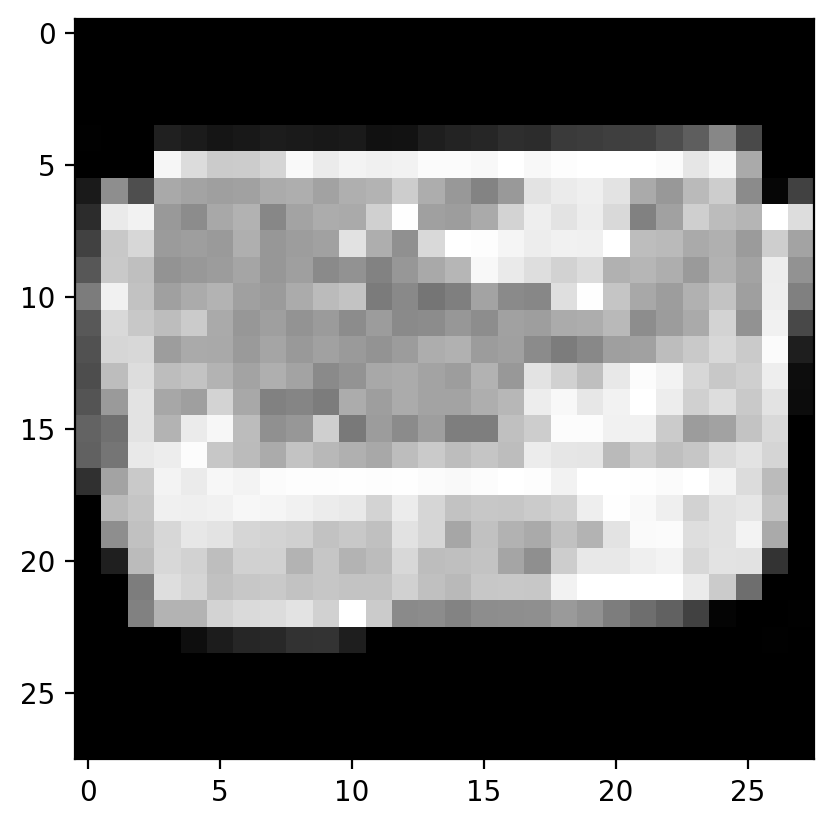

In [43]:
image, label = next(iter(train_dl))
print(image[0].shape, label.shape)
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray');

In [32]:
# build the network
def network():
    model = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 128)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),                                       
                                       ('fc2', nn.Linear(128, 64)),
                                       ('relu2', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),                                       
                                       ('output', nn.Linear(64, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # define the criterion and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    return model, loss_fn, optimizer, device   

In [33]:
model, loss_fn, optimizer, device = network()
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [34]:
def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=25):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        # Set mode to training - Dropouts will be used here
        model.train()
        train_epoch_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # flatten the images to batch_size x 784
            images = images.view(images.shape[0], -1)
            # forward pass
            outputs = model(images)
            # backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            # Weight updates
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
        else:
            # One epoch of training complete
            # calculate average training epoch loss
            train_epoch_loss = train_epoch_loss/len(trainloader)

            # Now Validate on testset
            with torch.no_grad():
                test_epoch_acc = 0
                test_epoch_loss = 0
                # Set mode to eval - Dropouts will NOT be used here
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)                    
                    # flatten images to batch_size x 784
                    images = images.view(images.shape[0], -1)
                    # make predictions 
                    test_outputs = model(images)
                    # calculate test loss
                    test_batch_loss = loss_fn(test_outputs, labels)
                    test_epoch_loss += test_batch_loss
                    
                    # get probabilities, extract the class associated with highest probability
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)
                    
                    # compare actual labels and predicted labels
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_epoch_acc += batch_acc.item()
                else:
                    # One epoch of training and validation done
                    # calculate average testing epoch loss
                    test_epoch_loss = test_epoch_loss/len(testloader)
                    # calculate accuracy as correct_pred/total_samples
                    test_epoch_acc = test_epoch_acc/len(testloader)
                    # save epoch losses for plotting
                    train_losses.append(train_epoch_loss)
                    test_losses.append(test_epoch_loss)
                    # print stats for this epoch
                    print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.19f}, val_loss: {test_epoch_loss:.19f}, ',
                          f'val_acc: {test_epoch_acc*100:.2f}%')
    # Finally plot losses
    plt.plot(train_losses, label='train-loss')
    plt.plot(test_losses, label='val-loss')
    plt.legend()
    plt.show()

Epoch: 0 -> train_loss: 0.5776641740798950098, val_loss: 0.4250100255012512207,  val_acc: 84.69%
Epoch: 1 -> train_loss: 0.4606372420787811506, val_loss: 0.4073224067687988281,  val_acc: 85.43%
Epoch: 2 -> train_loss: 0.4252054190436999059, val_loss: 0.3746406733989715576,  val_acc: 86.05%
Epoch: 3 -> train_loss: 0.4108445057471593054, val_loss: 0.3790001869201660156,  val_acc: 86.45%
Epoch: 4 -> train_loss: 0.3900975996057192696, val_loss: 0.3517253696918487549,  val_acc: 87.42%
Epoch: 5 -> train_loss: 0.3795259907046953929, val_loss: 0.3700467348098754883,  val_acc: 86.80%
Epoch: 6 -> train_loss: 0.3736503569483757281, val_loss: 0.3486128151416778564,  val_acc: 87.13%
Epoch: 7 -> train_loss: 0.3644294094145297813, val_loss: 0.3434810340404510498,  val_acc: 87.90%
Epoch: 8 -> train_loss: 0.3537531998554865331, val_loss: 0.3379572629928588867,  val_acc: 88.46%
Epoch: 9 -> train_loss: 0.3532231309215227988, val_loss: 0.3443603217601776123,  val_acc: 87.78%
Epoch: 10 -> train_loss: 0.350

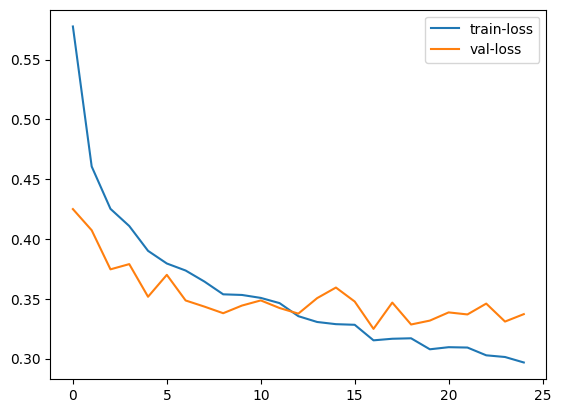

In [35]:
# Train and validate
train_validate(model, loss_fn, optimizer, train_dl, val_dl, device)

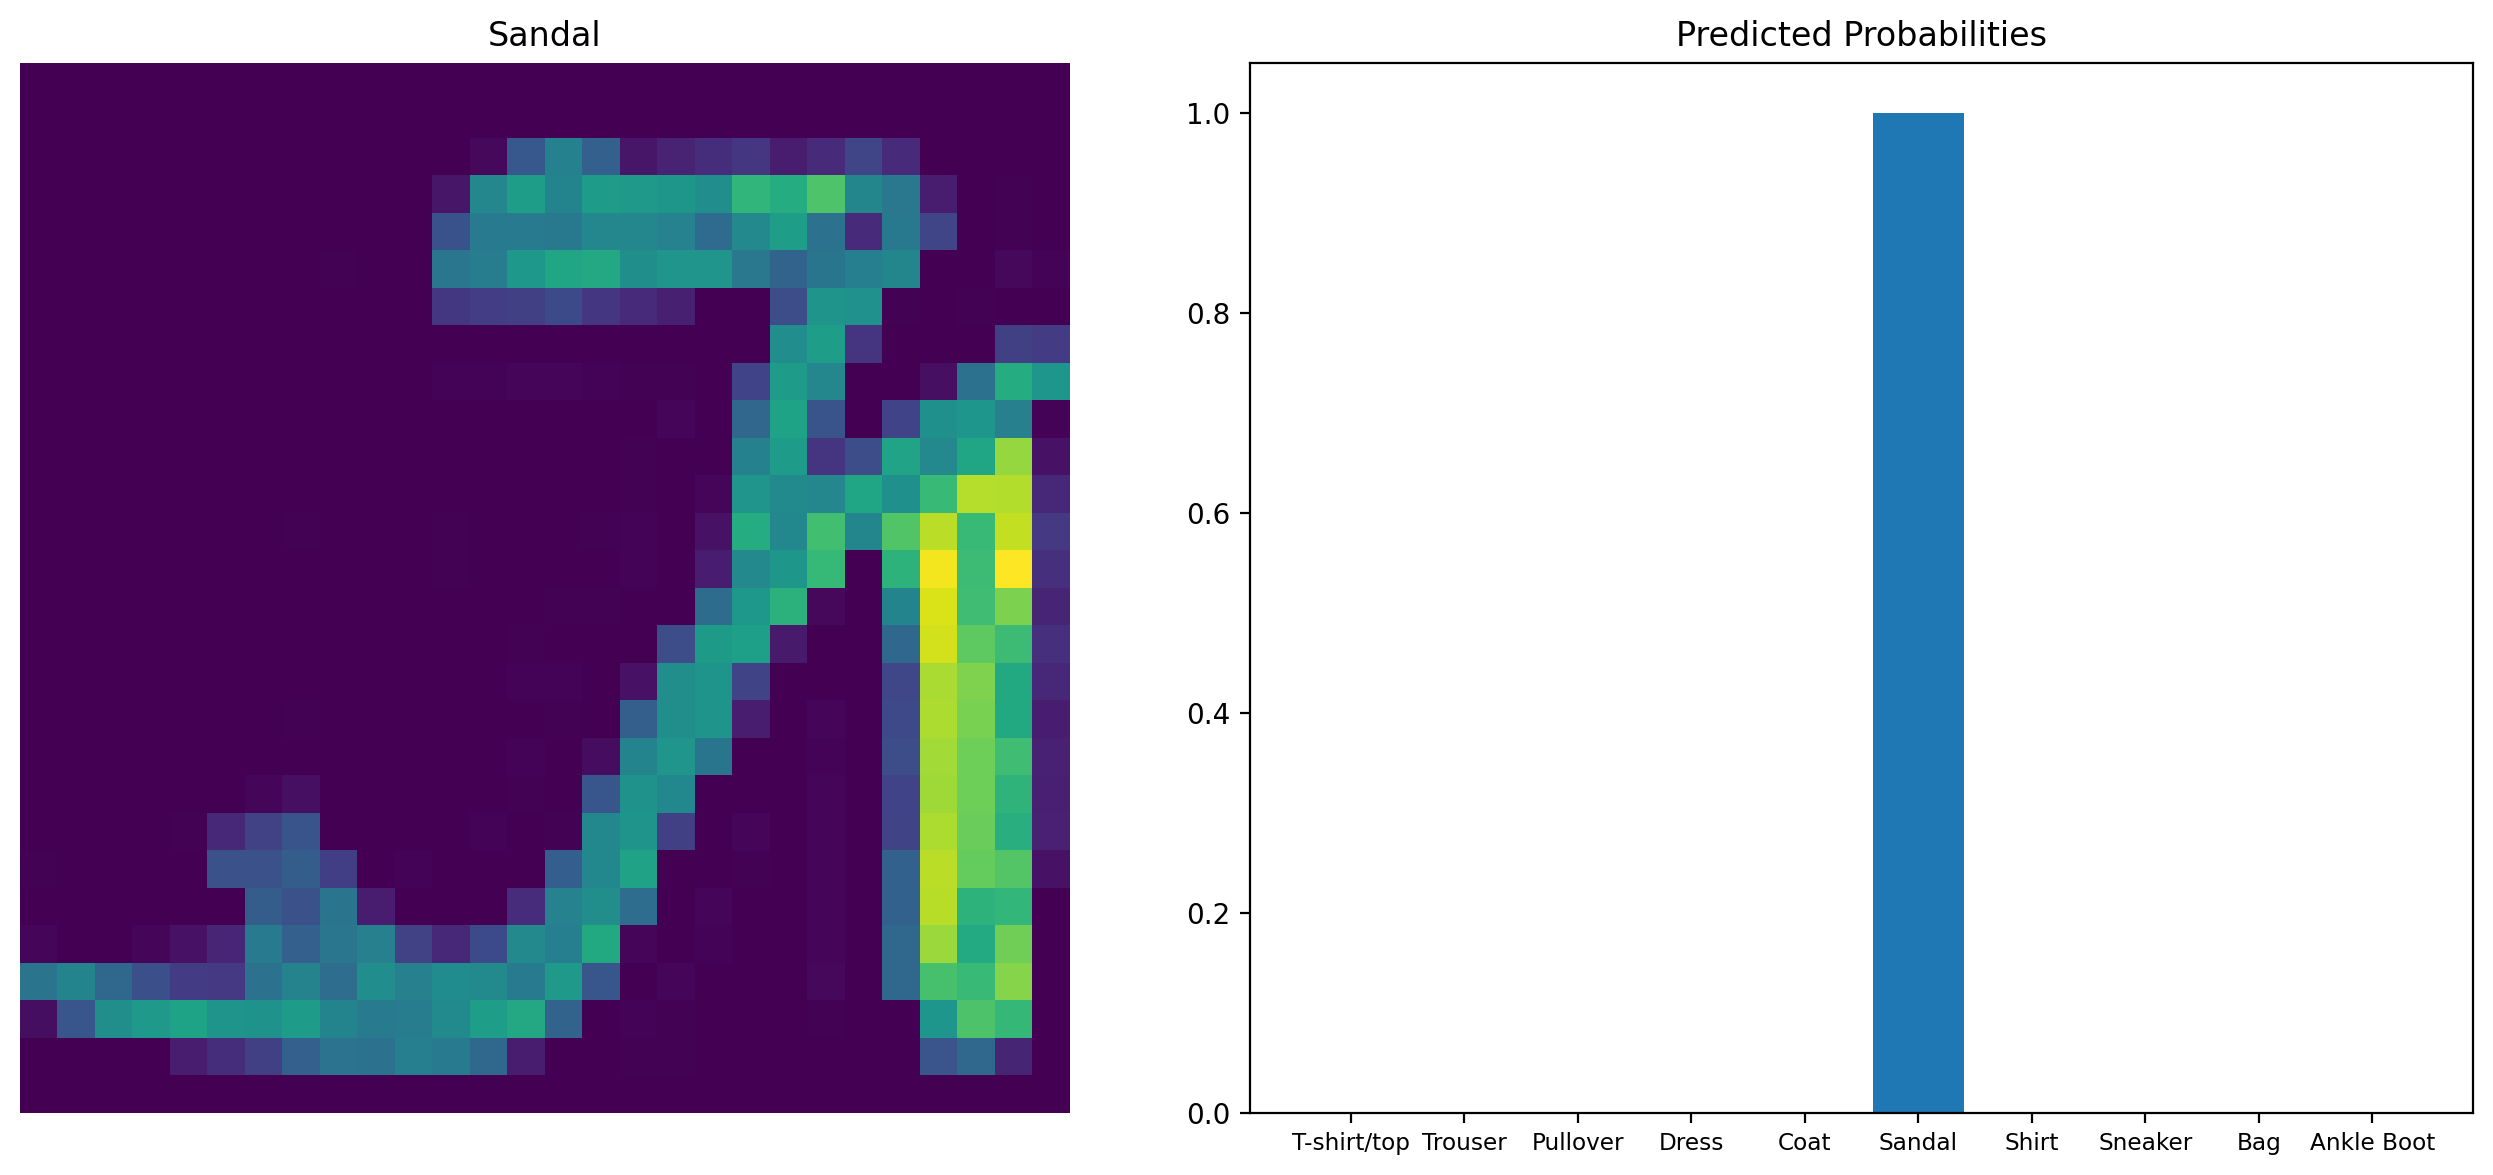

In [38]:
# predict single image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test out the network!
dataiter = iter(test_dl)
images, labels = next(dataiter)  # Directly fetch the data from the iterator

images, labels = images.to(device), labels.to(device)
index = 49
img, label = images[index], labels[index]
# Convert 2D image to 1D vector
img = img.view(img.shape[0], -1)

# Calculate the class probabilities (softmax) for img
proba = torch.exp(model(img))

# Plot the image and probabilities
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, (ax1, ax2) =  plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
ax1.axis('off')
ax1.imshow(images[index].cpu().numpy().squeeze())
ax1.set_title(desc[label.item()])
ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
ax2.set_xticks(range(10))
ax2.set_xticklabels(desc, size='small')
ax2.set_title('Predicted Probabilities')
plt.tight_layout()

In [39]:
# Validate
with torch.no_grad():
    batch_acc = []
    model.eval()
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        # flatten images to batch_size x 784
        images = images.view(images.shape[0], -1)
        # make predictions and get probabilities
        proba = torch.exp(model(images))
        # extract the class associted with highest probability
        _, pred_labels = proba.topk(1, dim=1)
        # compare actual labels and predicted labels
        result = pred_labels == labels.view(pred_labels.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        batch_acc.append(acc.item())
    else:
        print(f'Test Accuracy: {torch.mean(torch.tensor(batch_acc))*100:.2f}%')

Test Accuracy: 87.42%


## Evaluation